In [435]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [208]:
obs_per_day = 96
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Compute speed of sound in humid air

First attempt at removing flutter from Feather River data. Going to see how daily oscillations correlate with speed of sound in humid air, which is given by

$c = \sqrt{\gamma R T_K}$,

where $\gamma = c_p / c_v$ is the ratio of specific heats, $R$ is the specific gas constant and $T_K$ is the temperature in Kelvin. The specific heats are

$c_p = 1.005 + 1.82 H\ {\rm kJ / (kg\ K)}$ (need source for this...)

$c_v = c_p - R$,

where $H = \frac{\rho_v}{\rho_d}$ is absolute humidity and $R$ is the specific gas constant for humid air. The absolute humidity is given by

$\rho_v = \frac{p_v}{R_v T_K}$,

where $R_v = 461.495$ J/(kg K) is the specific gas constant for water vapor. The specific gas constant for humid air is

$R = \frac{p}{\rho_{\rm humid\ air} T_K} = \frac{p_d M_D + p_v M_v}{p_d / R_d + p_v / R_v}$

where $R_d = 287.058$ J/(kg K) is the specific gas constant for dry air, $p_v$ is the vapor pressure of water in the mixture, $p_d = p - p_v$ is the partial pressure of dry air and $p$ is the absolute pressure of the mixture. The molar masses of dry air and water vapor are $M_d = 0.028964$ kg/mol and $M_v=0.018016$ kg/mol.

Finally, the partial pressure $p_v$ is given by

$p_v = \phi p_{\rm sat}$,

where $\phi$ is the relative humidity and $p_{\rm sat}$ is the saturation vapor pressure. The Arden-Buck relation gives the saturation pressure for $-80^\circ {\rm C} < T_C < 50^\circ {\rm C}$:

$p_{\rm sat}(T) = 0.61121 \exp\left[\left( 18.678 - \frac{T_C}{234.5} \right) \left(\frac{T_C}{257.14 + T_C}\right) \right]$, $T > 0^\circ {\rm C}$

$p_{\rm sat}(T) = 0.61115 \exp\left[\left( 23.036 - \frac{T_C}{333.7} \right) \left(\frac{T_C}{279.82 + T_C}\right) \right]$, $T < 0^\circ {\rm C}$.

The tests below show that $p$ and $\phi$ have completely negligible effects on $c$.

In [43]:
R_v = 461.495 # J / (kg K)
R_d = 287.058 # J / (kg K)
M_d = 0.028964 # kg / mol
M_v = 0.018016 # kg / mol

In [44]:
def p_sat(T_C):
    """
    Returns: saturation vapor pressure in Pa
    """
    if T_C >= 0:
        return 1e3 * 0.61121 * np.exp((18.678 - T_C / 234.5) * (T_C / (257.14 + T_C)))
    else:
        return 1e3 * 0.61115 * np.exp((23.036 - T_C / 333.7) * (T_C / (279.82 + T_C)))

In [47]:
def c_air(T_C, rh, p):
    T_K = 273.0 + T_C
    
    p_v = (rh/100.0) * p_sat(T_C) # Pa
    
    R = p / ((p - p_v) / R_d + p_v / R_v) # J / (kg K)
    
    rho_v = p_v / (R_v * T_K)
    
    c_p = 1.005e3 + 1.82e3 * (rho_v / ((p - p_v) / (R_d * T_K)))
    c_v = c_p - R
    
    return np.sqrt(c_p / c_v * R * T_K)

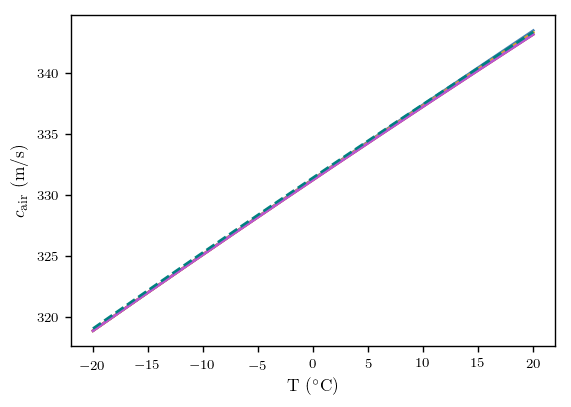

In [134]:
c_air_temps = np.linspace(-20, 20, 200)

plt.plot(c_air_temps, [c_air(t, 100.0, 101500.0) for t in c_air_temps])
plt.plot(c_air_temps, [c_air(t, 0.0, 101500.0) for t in c_air_temps])
plt.plot(c_air_temps, [c_air(t, 100.0, 201500.0) for t in c_air_temps])
plt.plot(c_air_temps, [c_air(t, 0.0,201500.0) for t in c_air_temps])
# Sensor's approximation
plt.plot(c_air_temps, [331.4*np.sqrt((t + 273.0)/273.0) for t in c_air_temps], '--')

plt.xlabel(r"T ($^\circ$C)")
plt.ylabel(r"$c_{\rm air}$ (m/s)")

## Compute speed of sound for Feather data

In [3]:
base_data_path = "../raw_data/feather_data/"

df_grzl = pd.read_csv(base_data_path + "GRZL.csv")
df_grzl["time"] = pd.to_datetime(df_grzl["time"])
df_macs_grzl = pd.read_csv(base_data_path + "GRZL_macs.csv")

df_ktl = pd.read_csv(base_data_path + "KTL.csv")
df_ktl["time"] = pd.to_datetime(df_ktl["time"])
df_macs_ktl = pd.read_csv(base_data_path + "KTL_macs.csv")

In [203]:
sensor = 0

# Choose time range to plot
i_ti = 27005
i_tf = 30850
times = df_grzl["time"].values[i_ti:i_tf]

# Extract data
snowdepths = df_grzl["snowdepth_%i" % sensor].values[i_ti:i_tf]
snowdepth_stdevs = df_grzl["snowdepth_stdev_%i" % sensor].values[i_ti:i_tf]
air_temps = df_grzl["air_temp_%i" % sensor].values[i_ti:i_tf]

# Compute speed of sound as function of temperature
#c_airs = np.asarray([c_air(T_C, 50.0, 101.2e3) for T_C in air_temps])

# Use single sensor's solar radiation as proxy for site
grzl_solar_rads = df_grzl["solar_rad_8"].values[i_ti:i_tf]

(736474.0, 736479.2083333334)

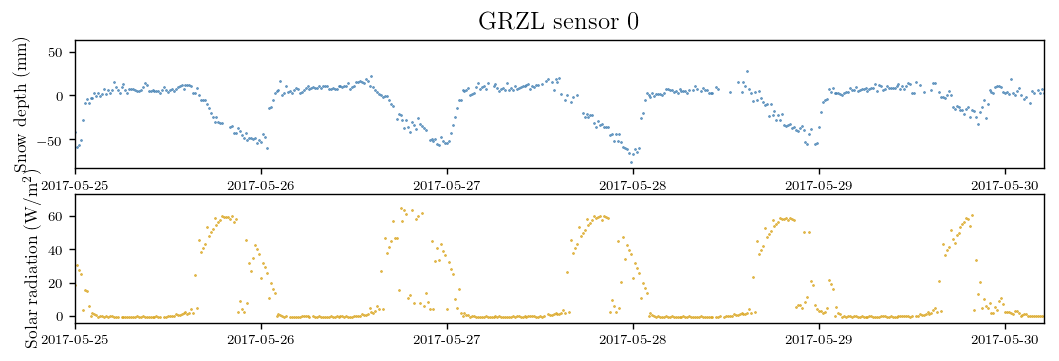

In [478]:
### Plot the data
plt.figure(figsize=(10, 3))

plt.subplot(2, 1, 1)
plt.title("GRZL sensor %i" % sensor)
plt.plot(times, snowdepths, '.', markersize=1)
#for t, sd, sd_stdev in zip(times, snowdepths, snowdepth_stdevs):
#    plt.plot([t, t], [sd-sd_stdev, sd+sd_stdev], '-', linewidth=0.5, color="steelblue")
plt.ylabel("Snow depth (mm)")
plt.xlim(min(times), times[500])

# plt.subplot(3, 1, 2)
# plt.plot(times, air_temps, '.', markersize=1, color=colors[1])
# plt.ylabel(r"Air temperature ($^\circ$C)")
# plt.xlim(min(times), times[500])

plt.subplot(2, 1, 2)
plt.plot(times, grzl_solar_rad, '.', markersize=1, color=colors[2])
plt.ylabel(r"Solar radiation (W/m$^2$)")
plt.xlim(min(times), times[500])

## Try linear regression onto solar radiation and air temperature as a function of time of day...

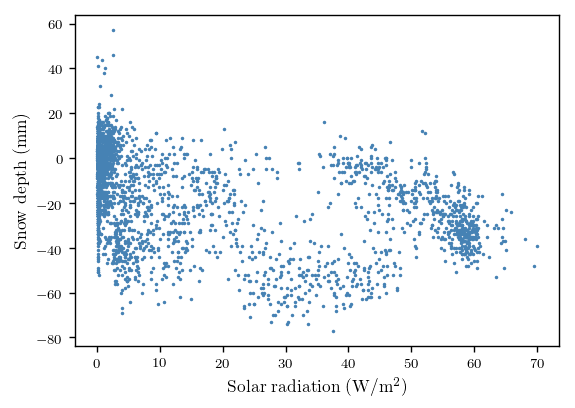

In [328]:
plt.scatter(solar_rads_shifted, snowdepths, s=1.0)
plt.xlabel(r"Solar radiation (W/m$^2$)")
plt.ylabel("Snow depth (mm)")

## Try computing sensor's temperature

$\frac{dQ}{dt} = h A (T_{\rm sensor}(t) - T_{\rm air}(t)) = \frac{A}{2} P_{\rm solar}(t) - \epsilon \sigma A T_{\rm sensor}^4(t)$,

where $A$ is the sensor's surface area. The emissivity $\epsilon$ is roughly 0.84 for white plastic (see <a href=http://www.thermoworks.com/learning/emissivity_table>this table</a>). This is very approximate, and since I don't know $h$, I'll just have to fiddle around.

In [137]:
from scipy.optimize import fsolve, root

In [290]:
# Try varying range of summer data used
ti_linreg = 0
tf_linreg = -1

solar_rads_shifted = grzl_solar_rads - np.nanmin(grzl_solar_rads)

# Need to mask out nans for linear regression
mask = ~np.isnan(snowdepths) & ~np.isnan(solar_rads_shifted) & ~np.isnan(air_temps)

# Choose some values for the hyperparameters 
eps = 0.84 # Emissivity (dimensionless)
sigma = 5.67e-8 # Stefan-Boltzman constant, W/(m^2 K^4)
hs = [0.01, 0.1, 1.0, 10.0] # Heat transfer coefficient (W / (K m^2))
T_sensor_h = np.zeros([len(hs), len(times)])

for j, h in enumerate(hs):
    # Compute sensor's temperature
    T_sensor_tmp = []
    for i, _ in enumerate(times):
        if mask[i]:
            T_sensor_tmp.append(fsolve(lambda t_s: h * (t_s - air_temps[i]) - 0.5 * solar_rads_shifted[i] + eps * sigma * (273 + t_s)**4, 10.0)[0])

    T_sensor = np.zeros(len(times))
    T_sensor[mask] = np.asarray(T_sensor_tmp).flatten()
    
    T_sensor_h[j, :] = T_sensor

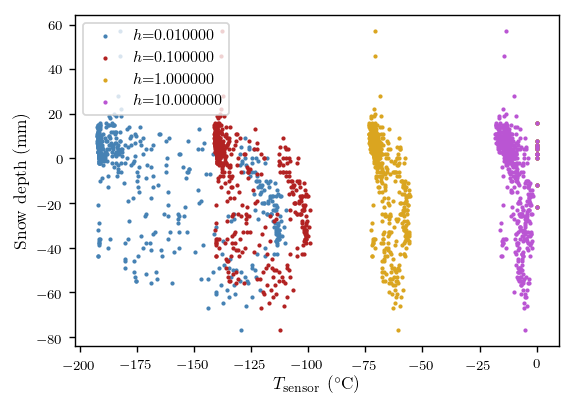

In [291]:
# Plot results
for j in range(T_sensor_h.shape[0]):
    plt.scatter(T_sensor_h[j, 0:700], snowdepths[0:700], s=2.0, label=r"$h$=%f" % hs[j])

plt.legend(loc="upper left")
plt.xlabel(r"$T_{\rm sensor}$ ($^\circ$C)")
plt.ylabel("Snow depth (mm)")

(736474.0, 736481.2916666666)

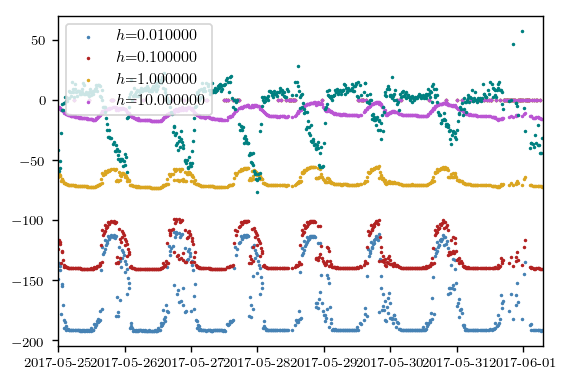

In [292]:
# Plot results
for j in range(T_sensor_h.shape[0]):
    plt.scatter(times[0:700], T_sensor_h[j, 0:700], s=1.0, label=r"$h$=%f" % hs[j])
    
plt.scatter(times[0:700], snowdepths[0:700], s=1.0)

plt.legend(loc="upper left")
plt.xlim(times[0], times[700])

## Try linear regression of summer snowdepths onto $T_{\rm air}$ and $P_{\rm solar}$
It's visually apparent that this works poorly.

In [331]:
# Try varying range of summer data used
ti_linreg = 0
tf_linreg = 1000

# Need to mask out nans for linear regression
mask = ~np.isnan(snowdepths) & ~np.isnan(grzl_solar_rads)# & ~np.isnan(air_temps)
# Mask out daytime
#mask[grzl_solar_rads > 0.25] = False

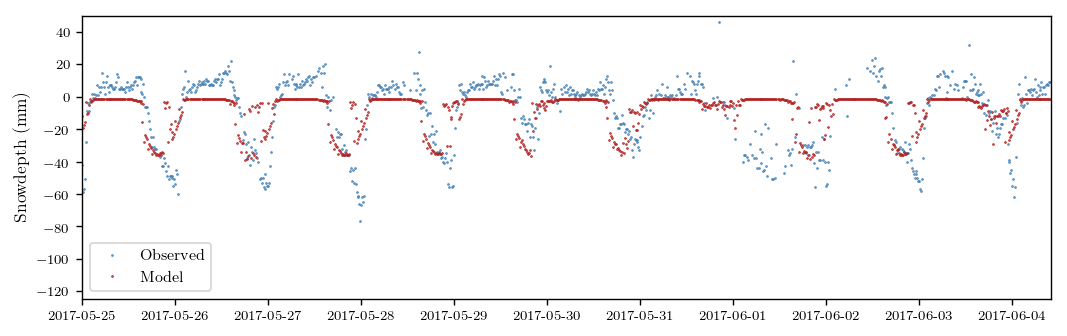

In [340]:
# Fit model
sd_linreg = LinearRegression()
#sd_linreg.fit(np.vstack([air_temps[mask][ti_linreg:tf_linreg], grzl_solar_rads[mask][ti_linreg:tf_linreg]]).T, snowdepths[mask][ti_linreg:tf_linreg])
sd_linreg.fit(grzl_solar_rads[mask][ti_linreg:tf_linreg].reshape(1, -1).T, snowdepths[mask][ti_linreg:tf_linreg])

# Compute predictions
predictions = np.zeros(len(times[ti_linreg:tf_linreg]))
for i in range(predictions.shape[0]):
    #T_a = air_temps[i]
    sr = grzl_solar_rads[i]
    
    if ~np.isnan(sr):
        predictions[i] = sd_linreg.predict(np.asarray([sr]).reshape(1, -1))
    else:
        predictions[i] = np.nan

# Plot data minus predictions
plt.figure(figsize=(10, 3))

plt.plot(times[ti_linreg:tf_linreg], snowdepths[ti_linreg:tf_linreg], '.', markersize=1.0, label="Observed")
plt.plot(times[ti_linreg:tf_linreg], predictions, '.', markersize=1.0, label="Model")
#plt.plot(times, grzl_solar_rads, '.', markersize=1.0)

plt.legend(loc="lower left")
plt.xlim(times[ti_linreg], times[tf_linreg])
plt.ylim(-125, 50)
plt.ylabel("Snowdepth (mm)")

## Try regressing onto last $s$ observations of $P_{\rm solar}$
This works poorly.

First, impute missing $P_{\rm solar}$ data using Kalman smoother

In [410]:
solar_rad_kf, _, _, _, _ = kalmanSmooth(grzl_solar_rads.reshape(1, -1), 
                                  grzl_solar_rads[0:1].reshape(1, 1),
                                  np.asarray([25]).reshape(1, 1),
                                  np.asarray([1]).reshape(1, 1),
                                  np.asarray([1]).reshape(1, 1),
                                  np.asarray([100]).reshape(1, 1),
                                  np.asarray([100]).reshape(1, 1), 1)

solar_rad_kf = solar_rad_kf.flatten()

Then construct the regression model

In [ ]:
lagged_linreg.residues_

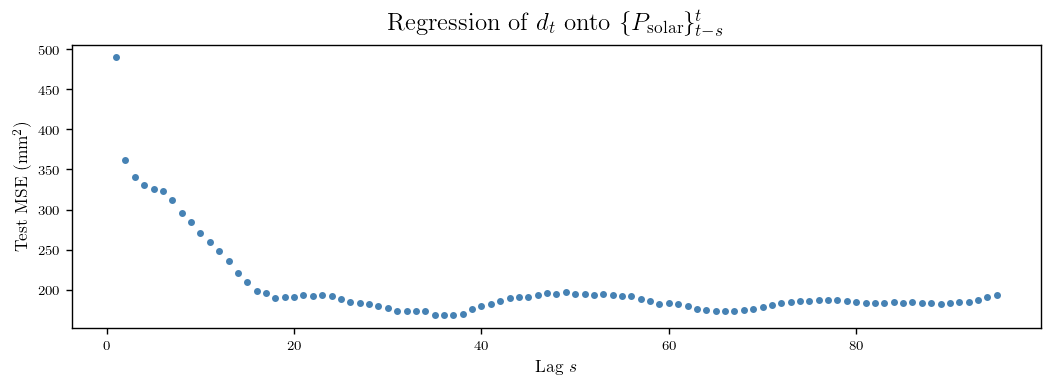

In [469]:
ti_tr, tf_tr = 0, 700
ti_ts, tf_ts = 2200, len(snowdepths)

lagged_linreg = LinearRegression()

# Loop over number of lagged observations of P_solar
ss = np.arange(1, 96)
mses = np.zeros(ss.size)

for i, s in enumerate(ss):
    ### Fit the model
    X = np.zeros([tf_tr - ti_tr - s, s])
    Y = snowdepths[ti_tr+s:tf_tr]

    # Construct independent variable matrix out of each set of most recent s measurements of P_solar
    for t in range(X.shape[0]):
        X[t, :] = np.power(solar_rad_kf[t:t+s] - min(solar_rad_kf[t:t+s]), 0.25)

    # Mask out points for which snow depth wasn't measured
    mask = ~np.isnan(Y)
    lagged_linreg.fit(X[mask, :], Y[mask])
    
    ### Use second half of summer data as test set
    X = np.zeros([tf_ts - ti_ts - s, s])
    Y = snowdepths[ti_ts+s:tf_ts]

    # Construct independent variable matrix out of each set of most recent s measurements of P_solar
    for t in range(X.shape[0]):
        X[t, :] = np.power(solar_rad_kf[ti_ts+t:ti_ts+t+s] - min(solar_rad_kf[ti_ts+t:ti_ts+t+s]), 0.25)

    # Mask out test points for which snow depth wasn't measured
    mask = ~np.isnan(Y)
    
    mses[i] = mean_squared_error(Y[mask], lagged_linreg.predict(X[mask, :]))

# Plot data minus predictions
plt.figure(figsize=(10, 3))

plt.plot(ss, mses, '.')

plt.title(r"Regression of $d_t$ onto $\{ P_{\rm solar} \}_{t-s}^t$")
plt.xlabel(r"Lag $s$")
plt.ylabel(r"Test MSE (mm$^2$)")

Plot predictions with lag of $s=20$

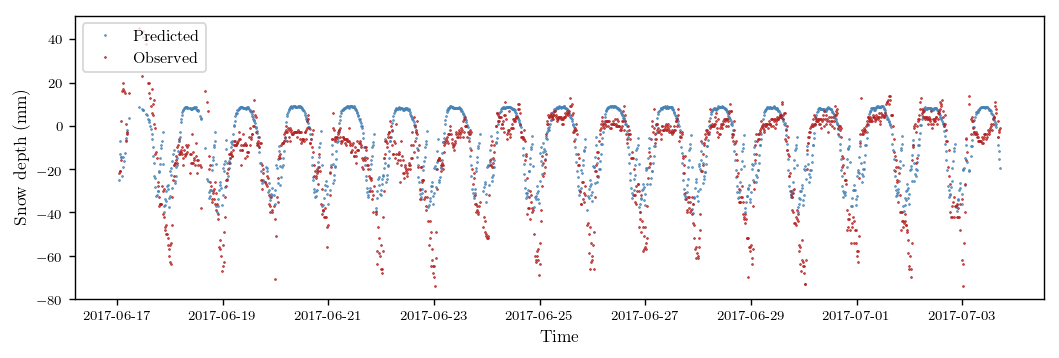

In [476]:
s = 12

# Fit model
X = np.zeros([tf_tr - ti_tr - s, s])
Y = snowdepths[ti_tr+s:tf_tr]
for t in range(X.shape[0]):
    X[t, :] = np.power(solar_rad_kf[t:t+s] - min(solar_rad_kf[t:t+s]), 0.5)
mask = ~np.isnan(Y)
lagged_linreg.fit(X[mask, :], Y[mask])

# Predict
X = np.zeros([tf_ts - ti_ts - s, s])
Y = snowdepths[ti_ts+s:tf_ts]

# Construct independent variable matrix out of each set of most recent s measurements of P_solar
for t in range(X.shape[0]):
    X[t, :] = np.power(solar_rad_kf[ti_ts+t:ti_ts+t+s] - min(solar_rad_kf[ti_ts+t:ti_ts+t+s]), 0.5)

# Mask out test points for which snow depth wasn't measured
mask = ~np.isnan(Y)

# Show observed and predicted snow depths
plt.figure(figsize=(10, 3))

plt.plot(times[ti_ts+s:tf_ts][mask], lagged_linreg.predict(X[mask, :]), '.', label="Predicted", markersize=1)
#plt.plot(times[ti_ts+s:tf_ts], grzl_solar_rads[ti_ts+s:tf_ts], '.', label="Solar", markersize=1)
plt.plot(times[ti_ts+s:tf_ts], Y, '.', label="Observed", markersize=1)

plt.xlabel("Time")
plt.ylabel("Snow depth (mm)")
plt.legend(loc="upper left")

## Try to make with average snow depth template

## Try regressing onto sum of past observations of $P_{\rm solar}$

In [360]:
np.isnan(grzl_solar_rads[0:1000]).sum()

16

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


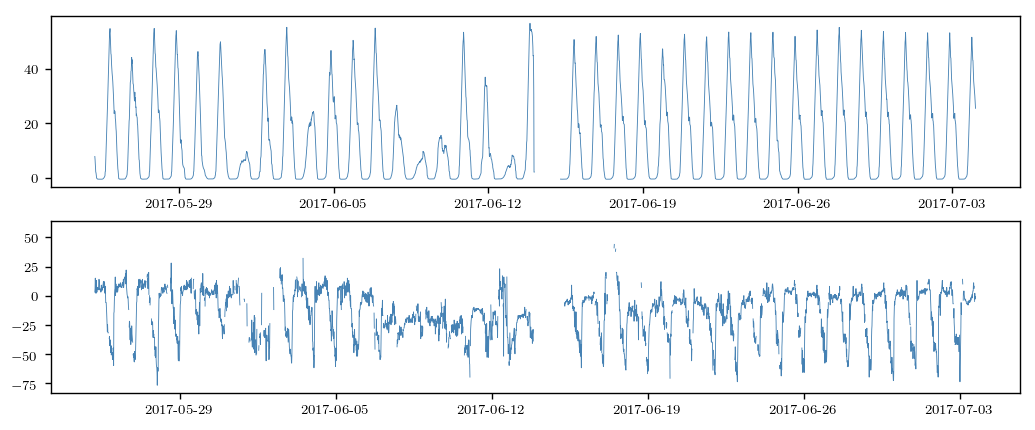

In [358]:
plt.figure(figsize=(10, 4))

window_size = 18

plt.subplot(2, 1, 1)
plt.plot(times[window_size:], [np.nanmean(grzl_solar_rads[t:t+window_size]) for t in range(grzl_solar_rads.size - window_size)], linewidth=0.5)

plt.subplot(2, 1, 2)
plt.plot(times[window_size:], snowdepths[window_size:], linewidth=0.5)

## Use night data to determine cooling rate

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


(736474.0, 736484.40625)

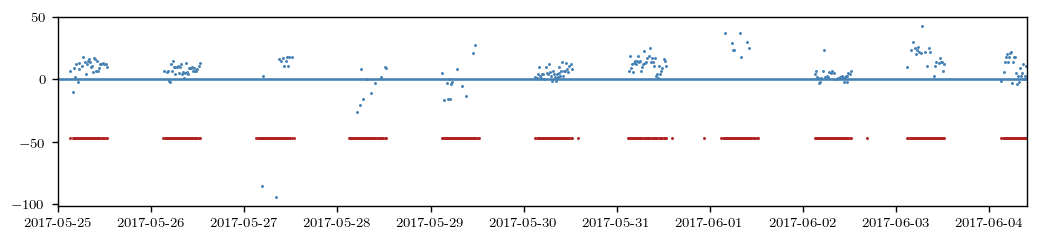

In [101]:
snowdepth_nightonly = snowdepths.copy()
snowdepth_nightonly[grzl_solar_rad > -0.25] = np.nan
air_temp_nightonly = air_temps.copy()
air_temp_nightonly[grzl_solar_rad > -0.25] = np.nan

plt.figure(figsize=(10, 2))
plt.scatter(times[0:1000], snowdepth_nightonly[0:1000], s=0.5)
plt.scatter(times[0:1000], air_temp_nightonly[0:1000], s=0.5)

plt.plot([min(times), max(times[0:1000])], [0, 0])

plt.xlim(min(times), max(times[0:1000]))

## Look for hysteresis
No discernable pattern: way too much noise

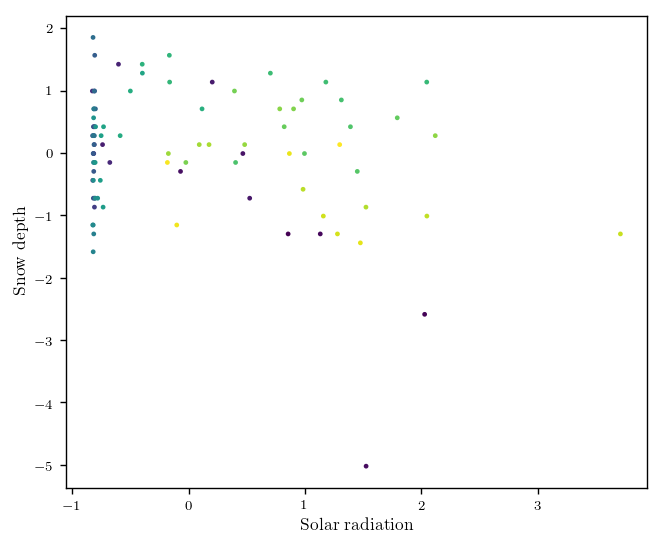

In [99]:
plt.figure(figsize=(6, 5))

plt.xlabel("Solar radiation")
plt.ylabel("Snow depth")

#for ti in range(0, len(times) - len(times) % 96, 96):

ti = 96 * 6

day_solar_rad_standardized = (grzl_solar_rad[ti:ti+96] - np.nanmean(grzl_solar_rad[ti:ti+96])) / np.nanstd(grzl_solar_rad[ti:ti+96])
day_snowdepth_standardized = (snowdepths[ti:ti+96] - np.nanmean(snowdepths[ti:ti+96])) / np.nanstd(snowdepths[ti:ti+96])

#plt.plot(day_solar_rad_standardized, day_snowdepth_standardized, linewidth=0.5)
plt.scatter(day_solar_rad_standardized, day_snowdepth_standardized, c=range(obs_per_day), s=3)

# Regression onto cumulative sum of $P_{\rm solar}$

In [1]:
from Stable_SSM_EM import *
import numpy as np
import pandas as pd
from dateutil import tz
from astral import Astral
from Utilities import *
from ModelTest import loadTestSets

In [2]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]

# Choose a network
df_feather_ktl = pd.read_csv("../raw_data/feather_data/%s.csv" % feather_wsns[0])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values
y_rad_raw = df_feather_ktl["solar_rad_8"].values
times = pd.to_datetime(df_feather_ktl["time"])

# Convert times to CA ones
utc_zone = tz.gettz("UTC")
ca_zone = tz.gettz("America/Los_Angeles")
times = np.array([t.replace(tzinfo=utc_zone).astimezone(ca_zone) for t in times])

# Get dawn/dusk times

def get_dawn_dusk(ts):
    a = Astral()
    a.solar_depression = "civil"
    city = a["Sacramento"]
    
    return np.array([city.sun(t)["sunrise"] for t in ts]), np.array([city.sun(t)["sunset"] for t in ts])

In [ ]:
ti, tf = 29060, 30500

for t in range(tf-ti):
    # Get dawn and dusk times
    dawn, dusk = get_dawn_dusk(times[ti+t:ti+t+1])
    # Append 1 if it's daytime, 0 if not
    ss.append(1 if dawn[0] < times[ti+t] < dusk[0] else 0)